<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2025/blob/main/Homeworks/HW04_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нейронные сети в биоинформатике

### Домашнее задание 4. Собираем свой GAN.

### О задании

В этом задании необходимо будет воссоздать архитектуру GAN (Generative Adversarial Networks) модели, состоящую из генератора и дискриминатора. В качестве данных будем использовать стандартный датасете MNIST. Хотим иметь возможность генерировать качественные изображения рукописных цифр по запросу.


In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from PIL import Image
from torch import autograd
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random

In [ ]:
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST # самый обычный MNIST

# Загрузка датасета

mnist = MNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.2MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Помещаем все значения в диапазон от 0 до 1

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Label:  5


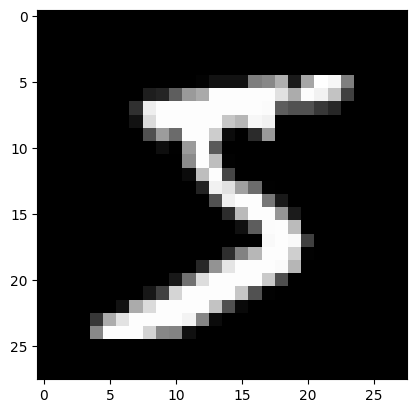

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

img, label = mnist[0]
print('Label: ', label)
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')

In [ ]:
img.shape

torch.Size([1, 28, 28])

In [ ]:
data_loader = torch.utils.data.DataLoader(mnist,
                                          batch_size=64,
                                          drop_last=True, # чтобы не было проблем с незаполненным последним батчем при работе с CNN
                                          shuffle=True)

# Задание 1. Простейший GAN
### Что такое GAN?

В 2014 году, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) опубликовали метод для тренировки генеративных моделей, который называется Generative Adversarial Networks (GANs).

Давайте воспроизведем архитектуру из этой статьи.

### Для начала вспомним в общем архитектуру GAN.
Генератор создает "изображения" из случайного шума и подает результат на вход дискриминатора. Дискриминатор обучается на реальных изображениях и на изображениях, сгенерированных генератором, выдает свою оценку, и градиенты используются для обновления весов как дискриминатора, так и генератора. Помним, что дискриминатор может быть слишком строгим, поэтому его можно обучать реже, либо сделать чуть лояльнее к генератору, используя дропауты.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/gan_scheme.png" alt="Drawing" width= "800px;"/>

Поскольку мы хотим иметь возможность генерировать изображения цифр по запросу, мы будем и генератору и дискриминатору передавать метку класса. То есть будем использовать архитектуру GAN с условиями (cGAN).


<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/gan_conditional_scheme.png" alt="Drawing" width= "800px;"/>

### Дискриминатор
Реализуйте архитектуру дискриминатора по приведенной ниже схеме

1. Полносвязный линейный слой с инпутом размера: размер изображения (28*28) + размер эмбеддинга меток (например, 10); и выходом 256
2. LeakyReLU с alpha=0.01
3. Полносвязный линейный слой с выходом 256
4. LeakyReLU с alpha=0.01
5. Полносвязный линейный слой с выходом 1
6. Функция активации (какая?)

LeakyRelu возвращает $f(x) = \max(\alpha x, x)$ с некой константой $\alpha$; здесь коэффициент нелинейности равен $\alpha=0.01$.

Аутпут дискриминатора должен содержать число, соответствующее вероятности изображения быть подлинным.



In [ ]:
?nn.LeakyReLU

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        #set_random_seed(42) # оставляем для воспроизводимости результатов
        super().__init__()

        # можно было закодировать one_hot, но мы захотели эмбеддинг меток
        # эмбеддинг просто дает более богатое представление и иногда позволяет сэкономить несколько слоев сети.
        # но здесь это не важно, будет работать что то, что то.
        # везде в дальнейшем оставляем эмбеддинг
        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            #in = 28 * 28 + 10
            nn.Linear(794, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        # В дискриминатор мы должны подать само изображение (28*28), склеенное с меткой
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels) #превращаем метку в массив чисел.
        x = torch.cat([x, c], 1)  #Добавляем в матрицу метку в виде массива чисел.
        out = self.model(x)
        return out.squeeze()

### Генератор
Теперь соберем, собственно, генератор
1. Полносвязный линейный слой с инпутом размера: размер вектора шума (например, 100) + размер эмбеддинга меток (10); и выходом 1024
2. ReLU
3. Полносвязный линейный слой с выходом 1024
4. ReLU
5. Полносвязный линейный слой с выходом 784
6. TanH - чтобы значения пикселей лежали в пределах [-1,1]

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        #set_random_seed(42)
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1) # и дискриминатор и генератор получают на вход информацию о метке
        out = self.model(x)
        return out.view(x.size(0), 28, 28) # разворачиваем линейный аутпут в картинку

В начале в качестве функции потерь будем использовать стандартный BCELoss

$$ bce(s, y) = y * \log(s) + (1 - y) * \log(1 - s) $$

In [ ]:
criterion = nn.BCELoss()

In [ ]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

В качестве оптимизатора будет использовать Adam с параметрами learning rate = 1e-3, betas = (0.5, 0.999)

In [ ]:
?torch.optim.Adam

In [ ]:
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))

g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))

Когда мы учим дискриминатор, мы передаем ему реальные объекты с метками + сгенерированные фейковые объекты с фейковыми метками, считаем loss по всем этим объектам, делаем backprop до весов дискриминатора и шаг по антиградиенту


In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # Подлинные изображения
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, torch.ones(batch_size).cuda())

    # Сгенерированные изображения
    z = torch.randn(batch_size, 100).cuda() # генерируем шум
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).cuda() # генерируем случайные метки для каждого изображения
    fake_images = generator(z, fake_labels) # собираем в картинку
    fake_validity = discriminator(fake_images, fake_labels) # дискриминатор будет сильно штрафовать генератор если тот сгенерил объект неправильно по метке.
    fake_loss = criterion(fake_validity, torch.zeros(batch_size).cuda())

    d_loss = real_loss + fake_loss

    d_loss.backward()
    d_optimizer.step()

    return d_loss.data

Теперь настроим шаг обучения генератора. Так же генерируем фейковые картинки и отдаем дискриминатору на оценку, считаем loss между уверенностью дискриминатора и единицами (чтобы оценить, насколько генератору удается обмануть дискриминатор), делаем backprop до весов генератора сквозь всю модель.

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = torch.randn(batch_size, 100).cuda()
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, torch.ones(batch_size).cuda())

    g_loss.backward()
    g_optimizer.step()

    return g_loss.data

Тренируем наш GAN

Starting epoch 0...
g_loss: 1.7770, d_loss: 1.0934


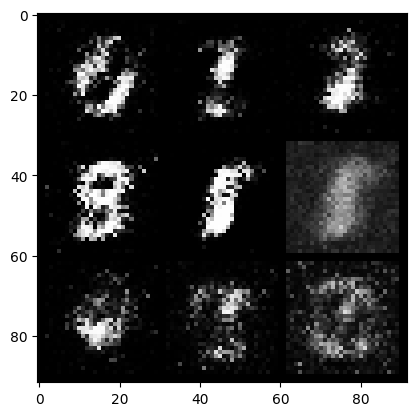

Starting epoch 1...
g_loss: 0.8387, d_loss: 1.3064


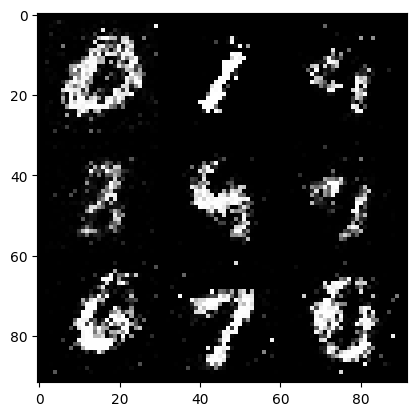

Starting epoch 2...
g_loss: 0.9076, d_loss: 1.2995


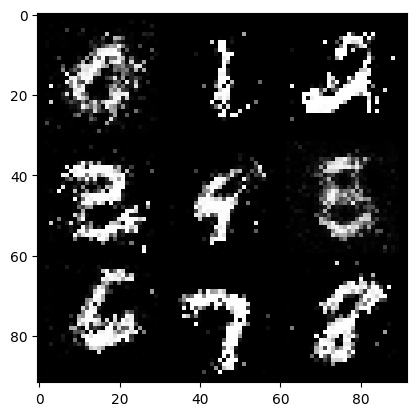

Starting epoch 3...
g_loss: 0.7843, d_loss: 1.2730


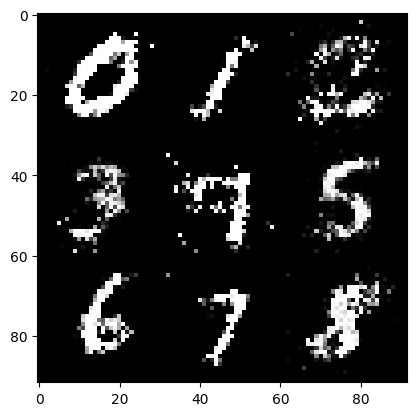

Starting epoch 4...
g_loss: 0.8819, d_loss: 1.3149


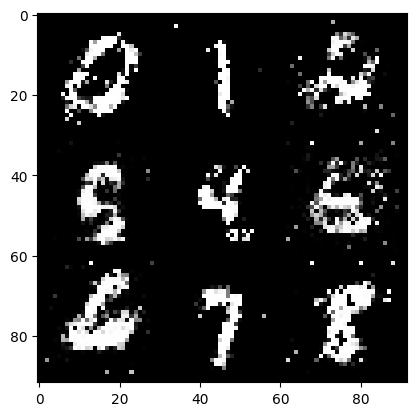

Starting epoch 5...
g_loss: 0.8266, d_loss: 1.3477


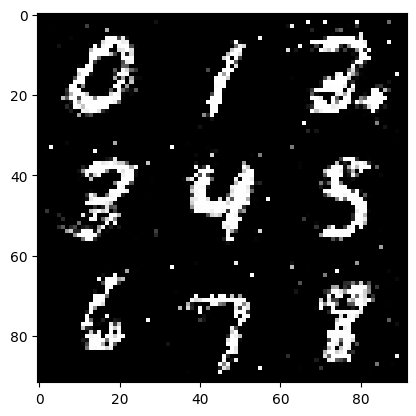

Starting epoch 6...
g_loss: 0.8330, d_loss: 1.3634


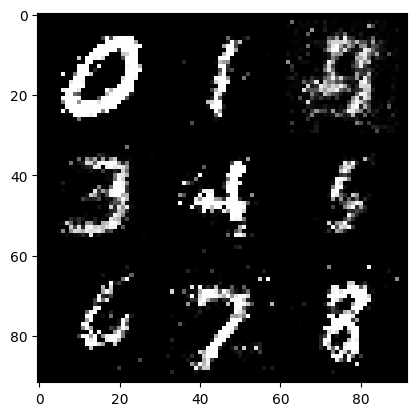

Starting epoch 7...
g_loss: 0.7914, d_loss: 1.4115


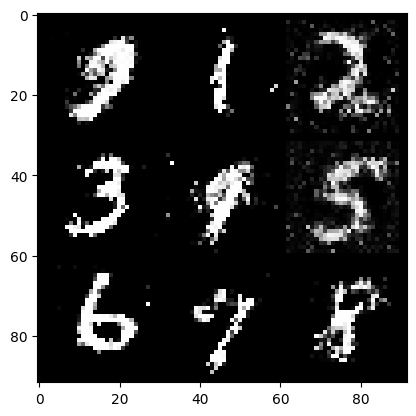

Starting epoch 8...
g_loss: 0.7484, d_loss: 1.3001


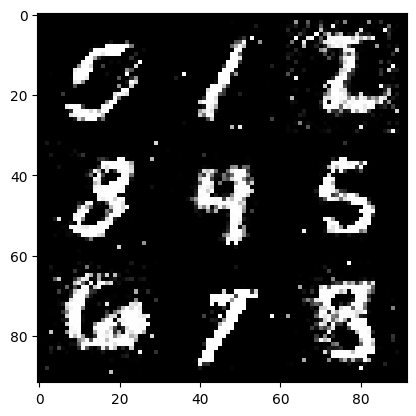

Starting epoch 9...
g_loss: 1.0764, d_loss: 1.1430


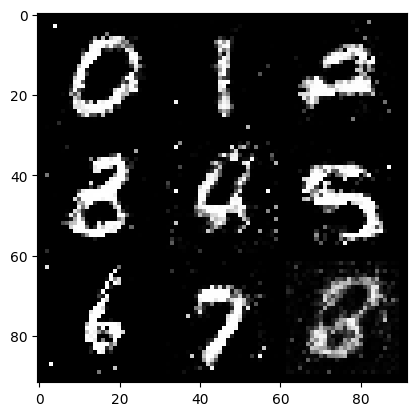

Starting epoch 10...
g_loss: 0.9647, d_loss: 1.1603


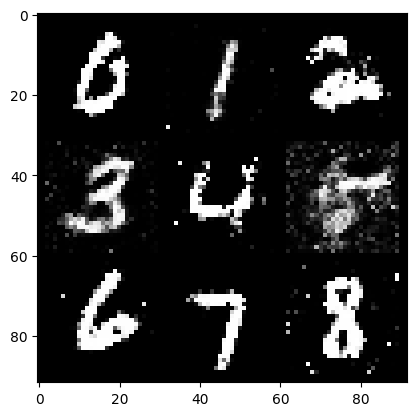

Starting epoch 11...
g_loss: 0.8575, d_loss: 1.2164


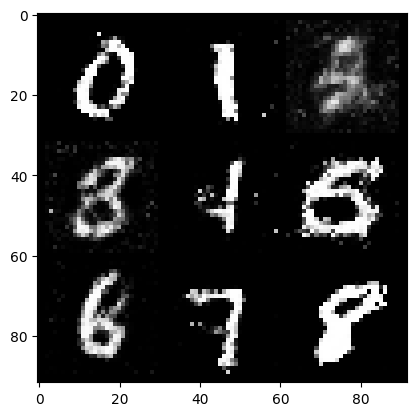

Starting epoch 12...
g_loss: 1.0868, d_loss: 1.1349


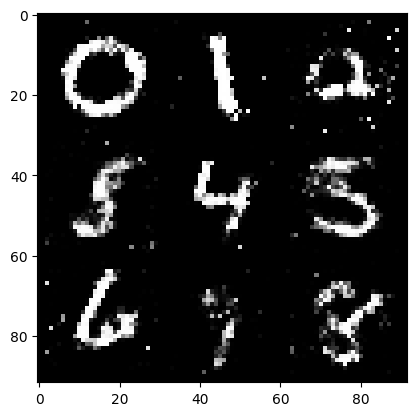

Starting epoch 13...
g_loss: 1.0213, d_loss: 1.2420


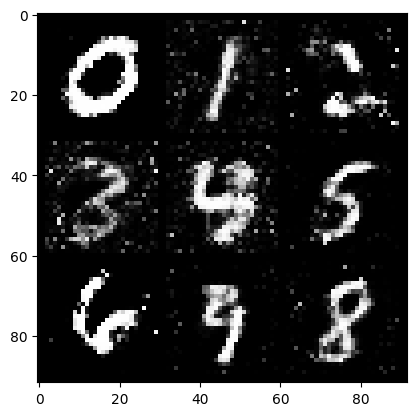

Starting epoch 14...
g_loss: 0.9328, d_loss: 1.3192


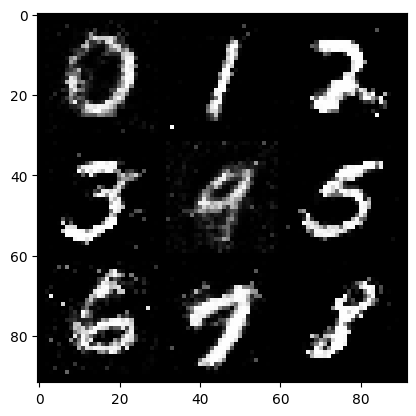

Starting epoch 15...
g_loss: 1.1309, d_loss: 1.1700


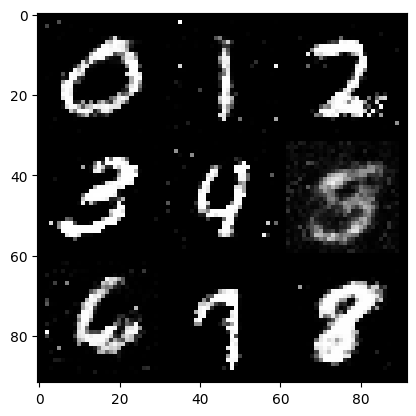

Starting epoch 16...
g_loss: 1.2479, d_loss: 1.1225


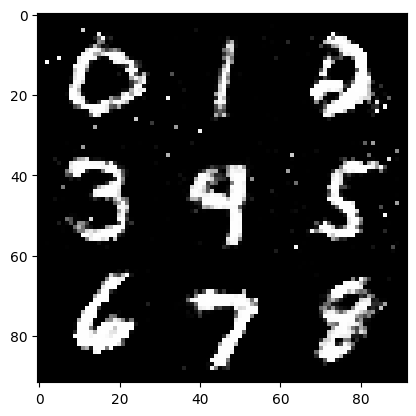

Starting epoch 17...
g_loss: 1.1271, d_loss: 1.1337


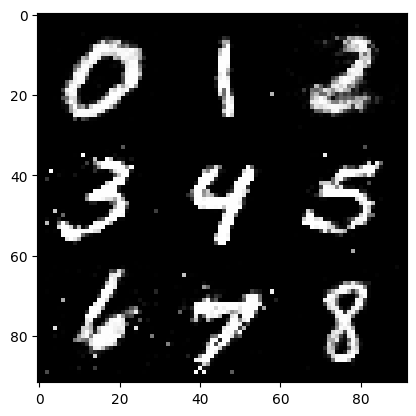

Starting epoch 18...
g_loss: 0.8956, d_loss: 1.2869


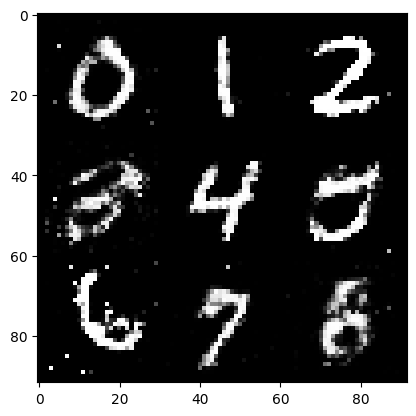

Starting epoch 19...
g_loss: 1.0021, d_loss: 1.1889


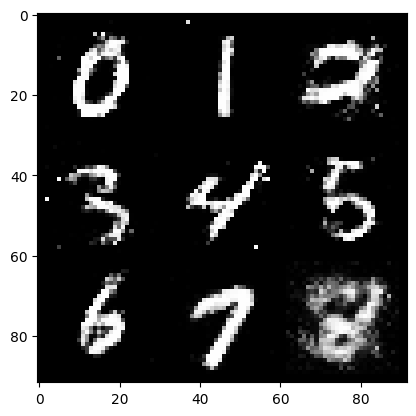

Starting epoch 20...
g_loss: 1.0955, d_loss: 1.2248


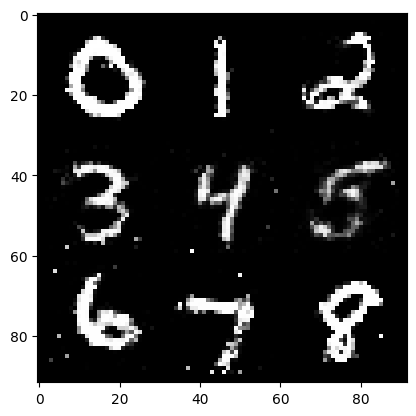

Starting epoch 21...
g_loss: 0.9835, d_loss: 1.1480


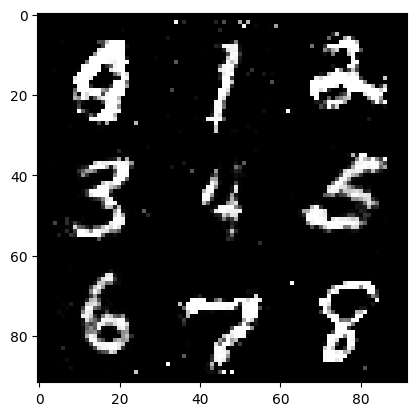

Starting epoch 22...
g_loss: 1.1492, d_loss: 1.2307


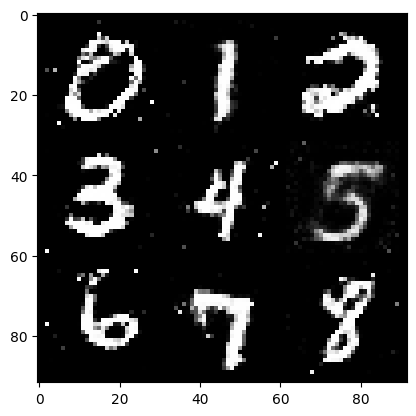

Starting epoch 23...
g_loss: 0.9805, d_loss: 1.1578


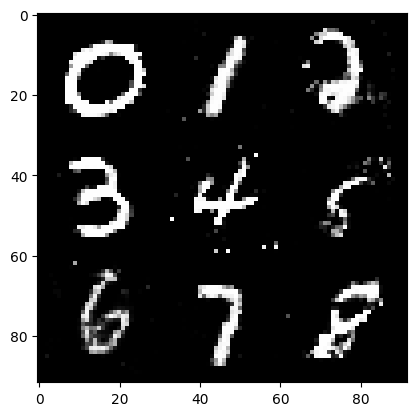

Starting epoch 24...
g_loss: 0.7835, d_loss: 1.1925


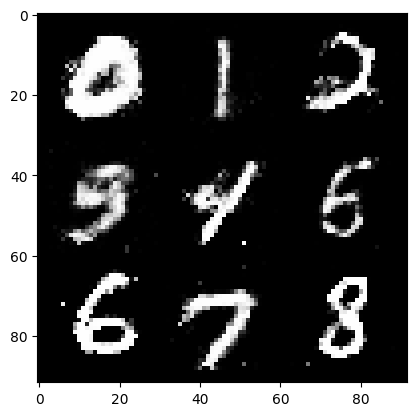

Starting epoch 25...
g_loss: 0.8891, d_loss: 1.2941


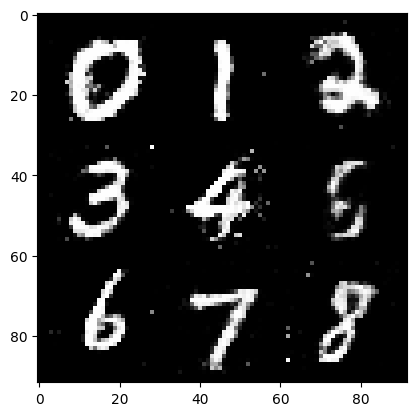

Starting epoch 26...
g_loss: 1.1344, d_loss: 1.2791


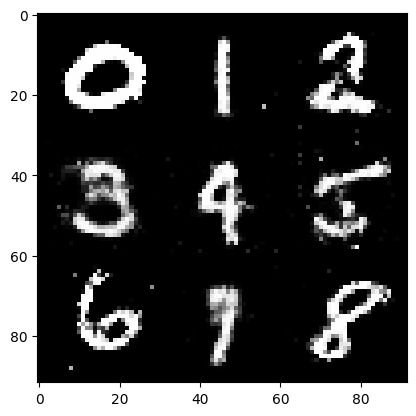

Starting epoch 27...
g_loss: 1.2409, d_loss: 1.1151


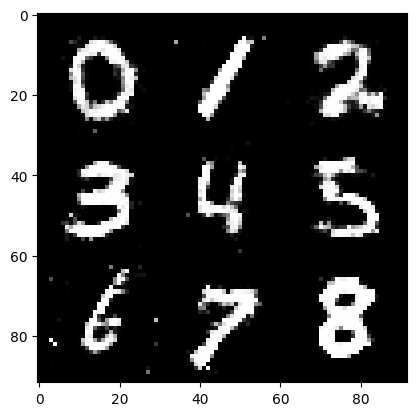

Starting epoch 28...
g_loss: 0.9753, d_loss: 1.2194


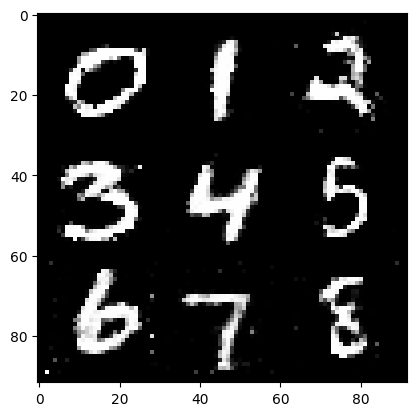

Starting epoch 29...
g_loss: 1.0182, d_loss: 1.2554


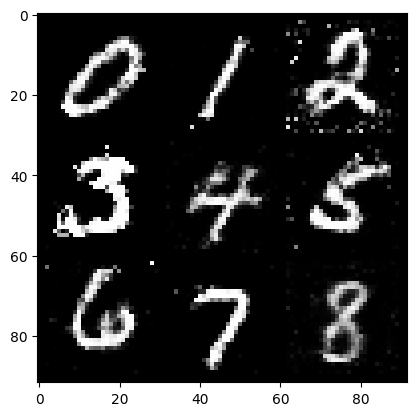

In [ ]:
num_epochs = 30
display_step = 300
for epoch in range(num_epochs):
    print(f'Starting epoch {epoch}...')
    for i, (images, labels) in enumerate(data_loader):
        real_images = images.cuda()
        labels = labels.cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)


        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print(f'g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}')
    z = torch.randn(9, 100).cuda()
    labels = torch.LongTensor(np.arange(9)).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

Смотрим как генерируются изображения по запросу

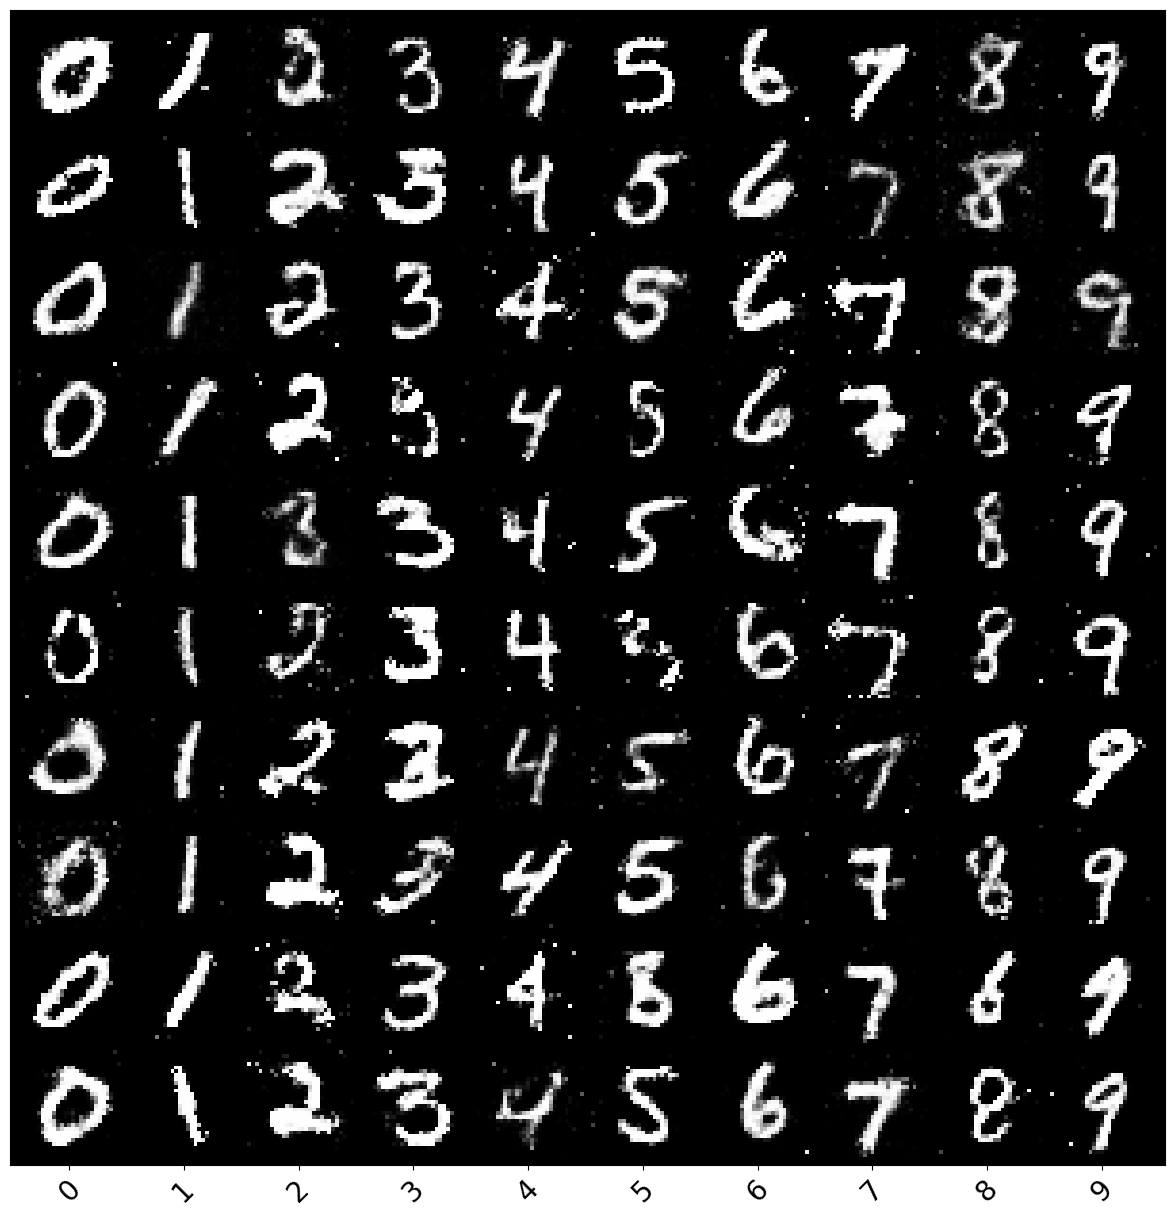

In [ ]:
z = torch.randn(100, 100).cuda()
labels = torch.LongTensor([i for _ in range(10) for i in range(10)]).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['0', '1', '2', '3',\
                                        '4', '5', '6', '7', '8',\
                                        '9'], rotation=45, fontsize=20)

Сделайте вывод относительно качества генерируемых изображений такой архитектурой.

У генератора есть проблемы с генерацией слишком извилистых линий, так ему легче генерировать 1, 2, 3, 9, 7, но не числа у которые состоят из дуговых линий и окружностей.

# Задание 2. Least Squares GAN
Теперь мы рассмотрим [Least Squares GAN](https://arxiv.org/abs/1611.04076), новую, более стабильную альтернативу исходной функции потерь GAN.
LSGAN использует квадратичную функцию потерь вместо логарифмической, чтобы стабилизировать обучение и избежать проблем с градиентами.

В этой части нам нужно только изменить функцию потерь и переобучить модель. Мы будем реализовывать уравнение (9) из статьи, где функция потерь генератора имеет вид:

Функция потерь генератора:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
Здесь мы хотим, чтобы дискриминатор $D(G(z))$ оценивал сгенерированные данные $G(z)$ как реальные (или близкие к 1)

Функция потерь дискриминатора
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$
Теперь мы хотим, чтобы дискриминатор оценивал реальные данные $D(x)$ как подлинные, а аутпут генератора $D(G(z))$ - как фейк


**Замечание**: Вместо расчета матожидания $\mathbb{E}$ будем брать среднее значение по элементам минибатча `torch.mean`. В качестве результатов дискриминатора $D(x)$ и $D(G(z))$ используем прямой атупут генератора (`scores_real` and `scores_fake`).

In [ ]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.

    Inputs:
    - scores_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Variable of shape (N,) giving scores for the fake data.

    Outputs:
    - loss: A PyTorch Variable containing the loss.
    """
    N = scores_real.size()
    loss = (0.5 * torch.mean((scores_real-torch.ones(N).cuda())**2)) + (0.5 * torch.mean(scores_fake**2))
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.

    Inputs:
    - scores_fake: PyTorch Variable of shape (N,) giving scores for the fake data.

    Outputs:
    - loss: A PyTorch Variable containing the loss.
    """
    N = scores_fake.size()
    loss = (0.5 * torch.mean((scores_fake-torch.ones(N).cuda())**2))
    return loss

In [ ]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

Добавим значения бетта 1 и бетта 2 к Адаму, без этого изменения дискриминатор очень быстро достигает значения 0 и генератор не учится

In [ ]:
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3, betas = (0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas = (0.5, 0.999))

In [ ]:
def ls_discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # Тренировка на подлинных изображениях
    real_validity = discriminator(real_images, labels)

    # Тренировка на фейковых изображениях
    z = torch.randn(batch_size, 100).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels) # дискриминатор будет сильно штрафовать генератор если тот сгенерил объект неправильно по метке.

    d_loss_real = criterion(real_validity, torch.ones_like(real_validity)).to(device) #E_{x~p_data} [(D(x) - 1)^2]
    d_loss_fake = criterion(fake_validity, torch.zeros_like(fake_validity)).to(device) #E_{z~p(z)} [(D(G(z)))^2]
    d_loss = (d_loss_real + d_loss_fake) / 2

    d_loss.backward()
    d_optimizer.step()

    return d_loss.data

In [ ]:
def ls_generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()

    z = torch.randn(batch_size, 100).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)

    #ℓ_G = (1/2) * E_{z~p(z)} [(D(G(z)) - 1)^2]
    g_loss = 0.5 * criterion(validity, torch.ones_like(validity))

    d_loss.backward()
    d_optimizer.step()

    return g_loss.data

Starting epoch 0...
g_loss: 1.3807, d_loss: 1.1482


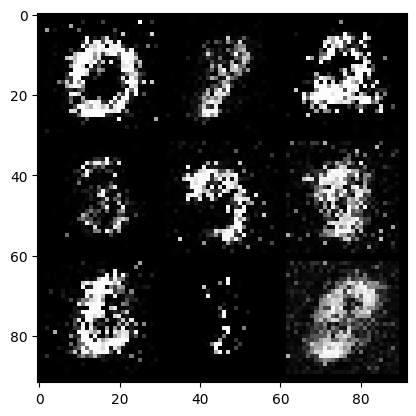

Starting epoch 1...
g_loss: 0.6212, d_loss: 1.4737


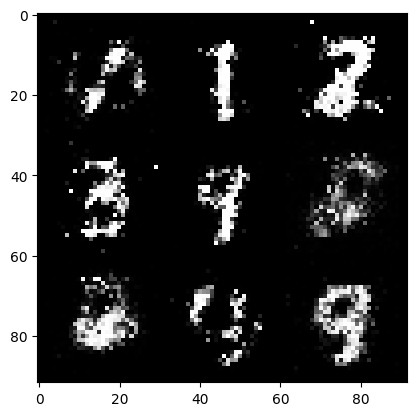

Starting epoch 2...
g_loss: 0.7500, d_loss: 1.2994


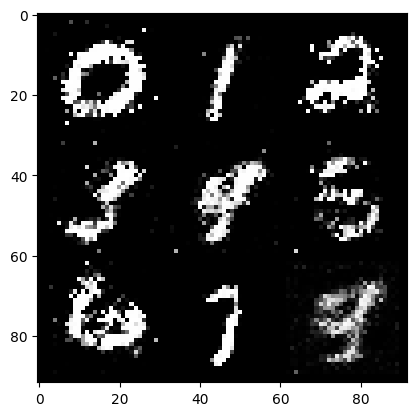

Starting epoch 3...
g_loss: 0.8164, d_loss: 1.4228


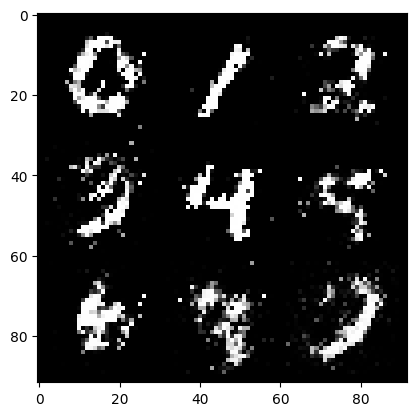

Starting epoch 4...
g_loss: 0.7954, d_loss: 1.3802


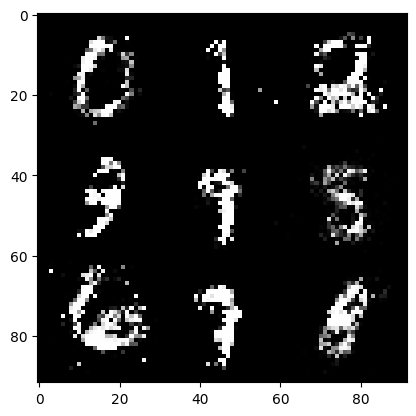

Starting epoch 5...
g_loss: 0.7334, d_loss: 1.4292


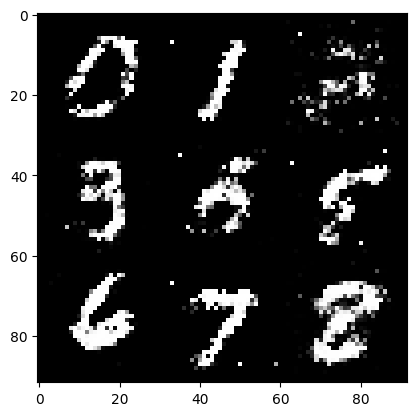

Starting epoch 6...
g_loss: 0.7590, d_loss: 1.3883


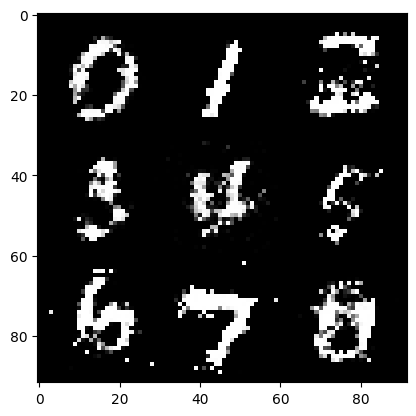

Starting epoch 7...
g_loss: 0.7823, d_loss: 1.3257


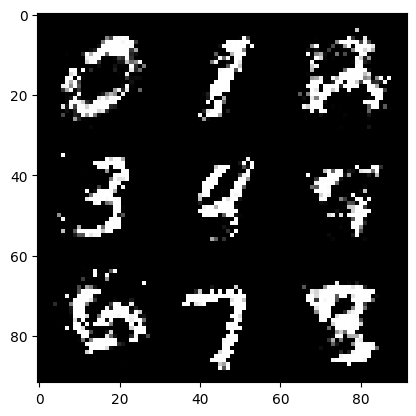

Starting epoch 8...
g_loss: 0.7948, d_loss: 1.3530


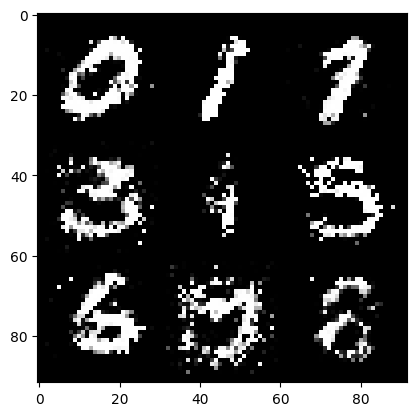

Starting epoch 9...
g_loss: 0.7229, d_loss: 1.3752


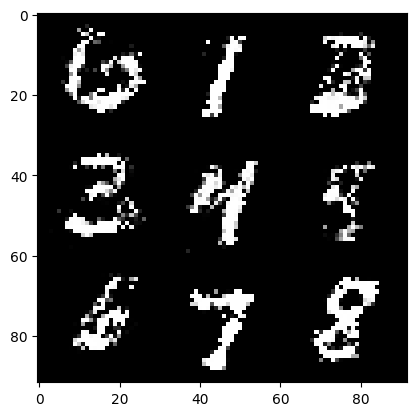

Starting epoch 10...
g_loss: 0.7518, d_loss: 1.3393


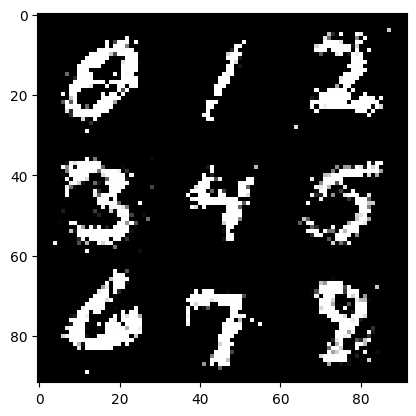

Starting epoch 11...
g_loss: 0.7675, d_loss: 1.3702


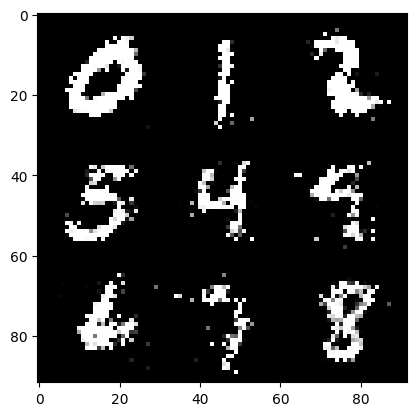

Starting epoch 12...
g_loss: 0.8623, d_loss: 1.1792


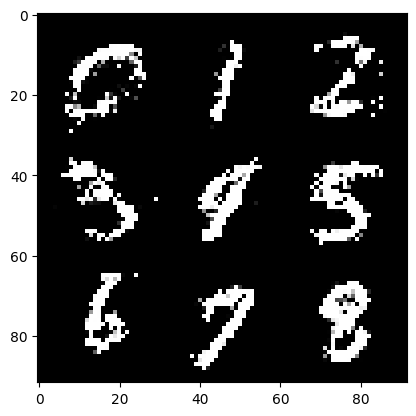

Starting epoch 13...
g_loss: 1.2528, d_loss: 1.2219


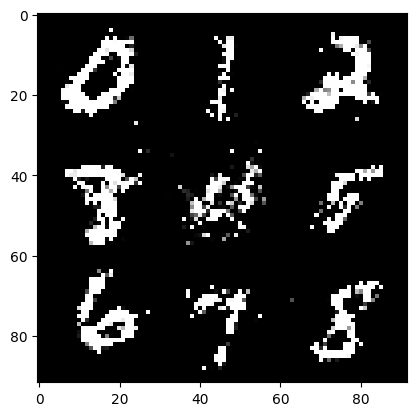

Starting epoch 14...
g_loss: 1.0195, d_loss: 1.1673


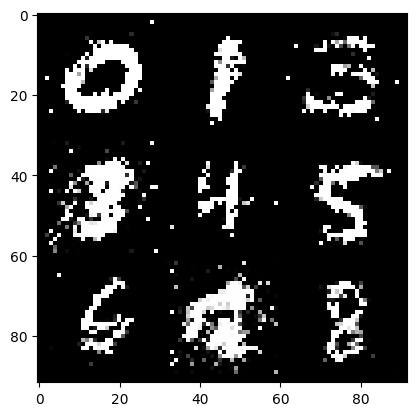

Starting epoch 15...
g_loss: 1.5868, d_loss: 1.1766


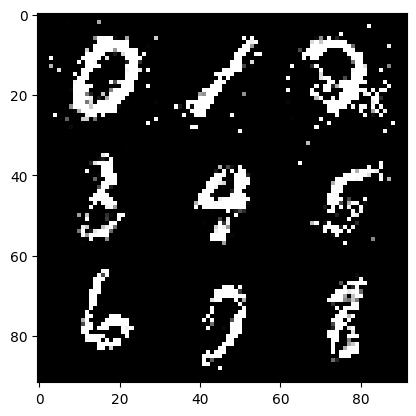

Starting epoch 16...
g_loss: 0.9992, d_loss: 0.9925


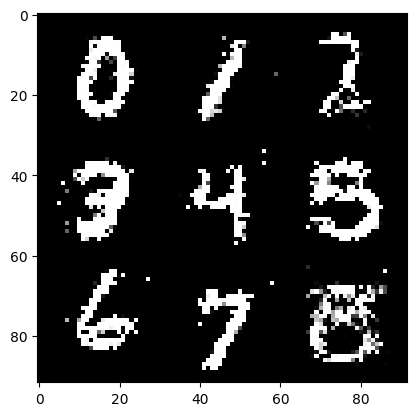

Starting epoch 17...
g_loss: 1.7706, d_loss: 0.7789


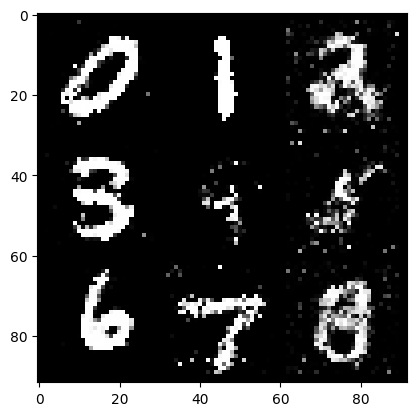

Starting epoch 18...
g_loss: 1.5301, d_loss: 0.9476


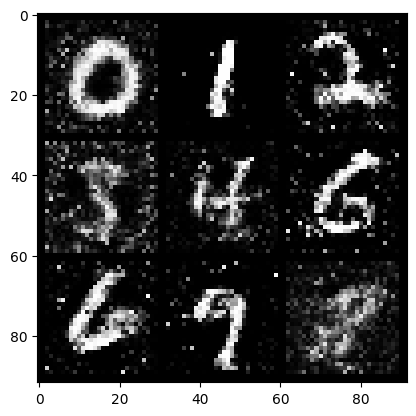

Starting epoch 19...
g_loss: 1.2262, d_loss: 0.9146


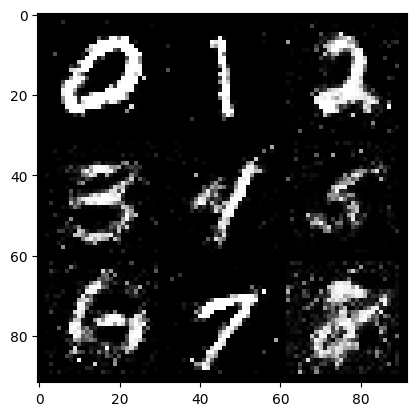

Starting epoch 20...
g_loss: 1.1748, d_loss: 1.0755


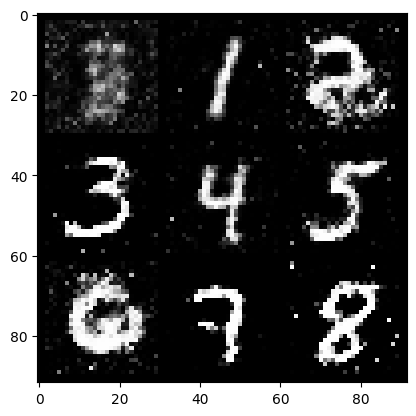

Starting epoch 21...
g_loss: 1.6149, d_loss: 1.1117


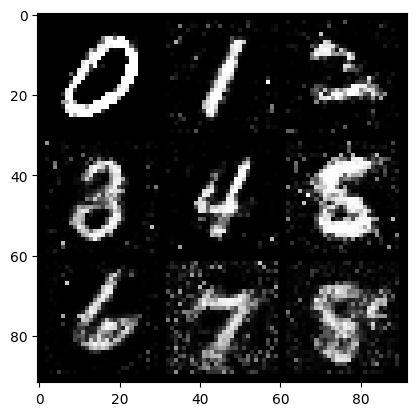

Starting epoch 22...
g_loss: 1.1712, d_loss: 1.0386


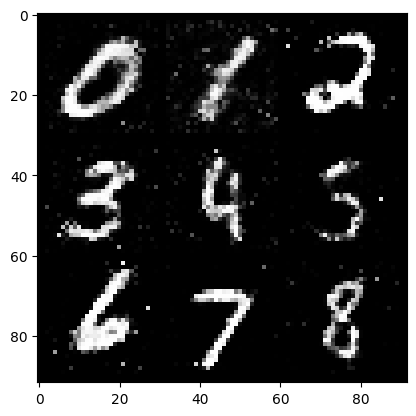

Starting epoch 23...
g_loss: 1.0816, d_loss: 1.2395


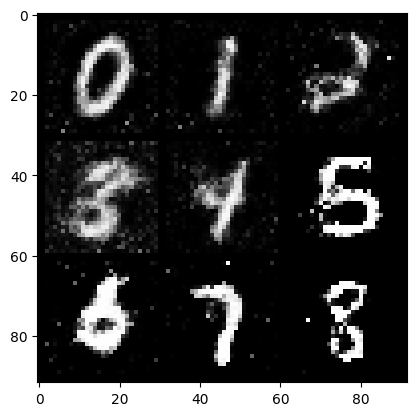

Starting epoch 24...
g_loss: 0.9719, d_loss: 1.2071


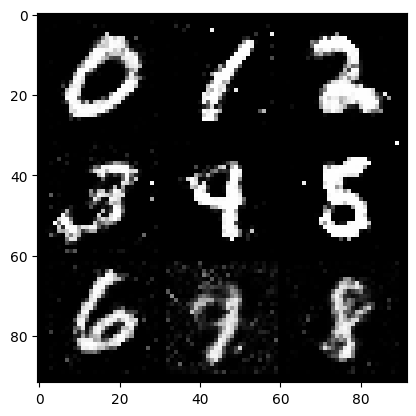

Starting epoch 25...
g_loss: 1.0454, d_loss: 1.1762


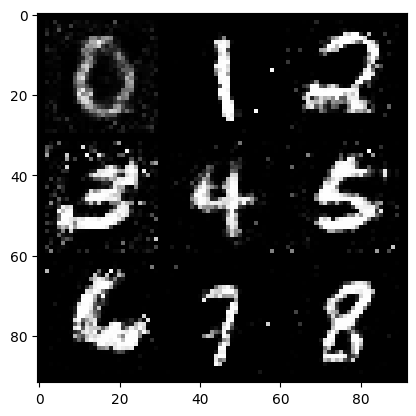

Starting epoch 26...
g_loss: 0.9343, d_loss: 1.2916


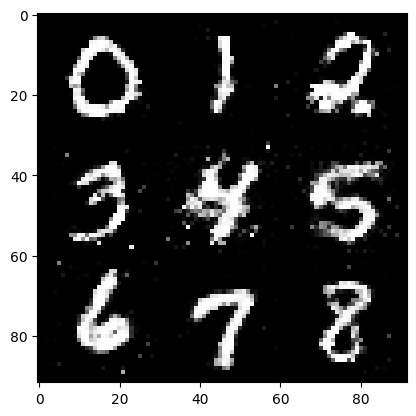

Starting epoch 27...
g_loss: 1.1128, d_loss: 1.1709


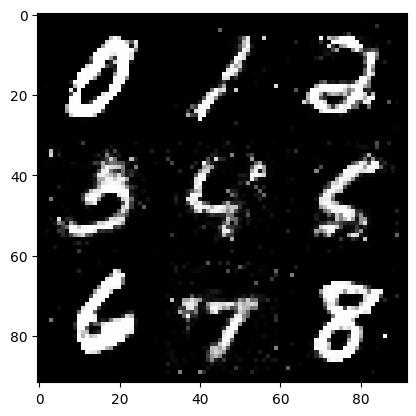

Starting epoch 28...
g_loss: 0.9816, d_loss: 1.0948


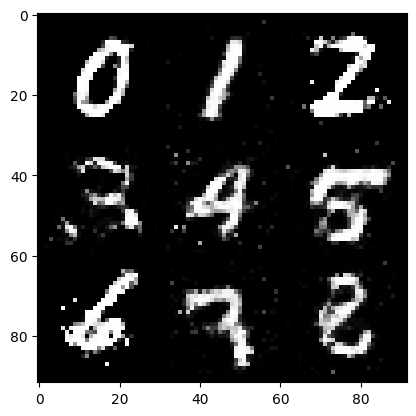

Starting epoch 29...
g_loss: 0.9301, d_loss: 1.2233


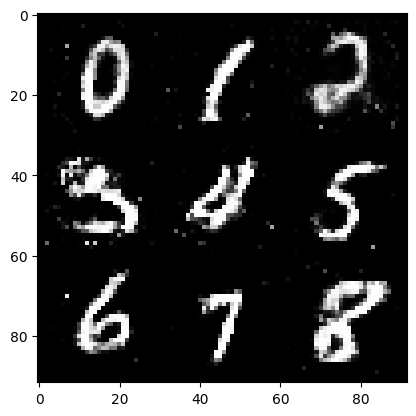

In [ ]:
num_epochs = 30
display_step = 300
for epoch in range(num_epochs):
    print(f'Starting epoch {epoch}...')
    for i, (images, labels) in enumerate(data_loader):
        real_images = images.cuda()
        labels = labels.cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print(f'g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}')
    z = torch.randn(9, 100).cuda()
    labels = torch.LongTensor(np.arange(9)).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

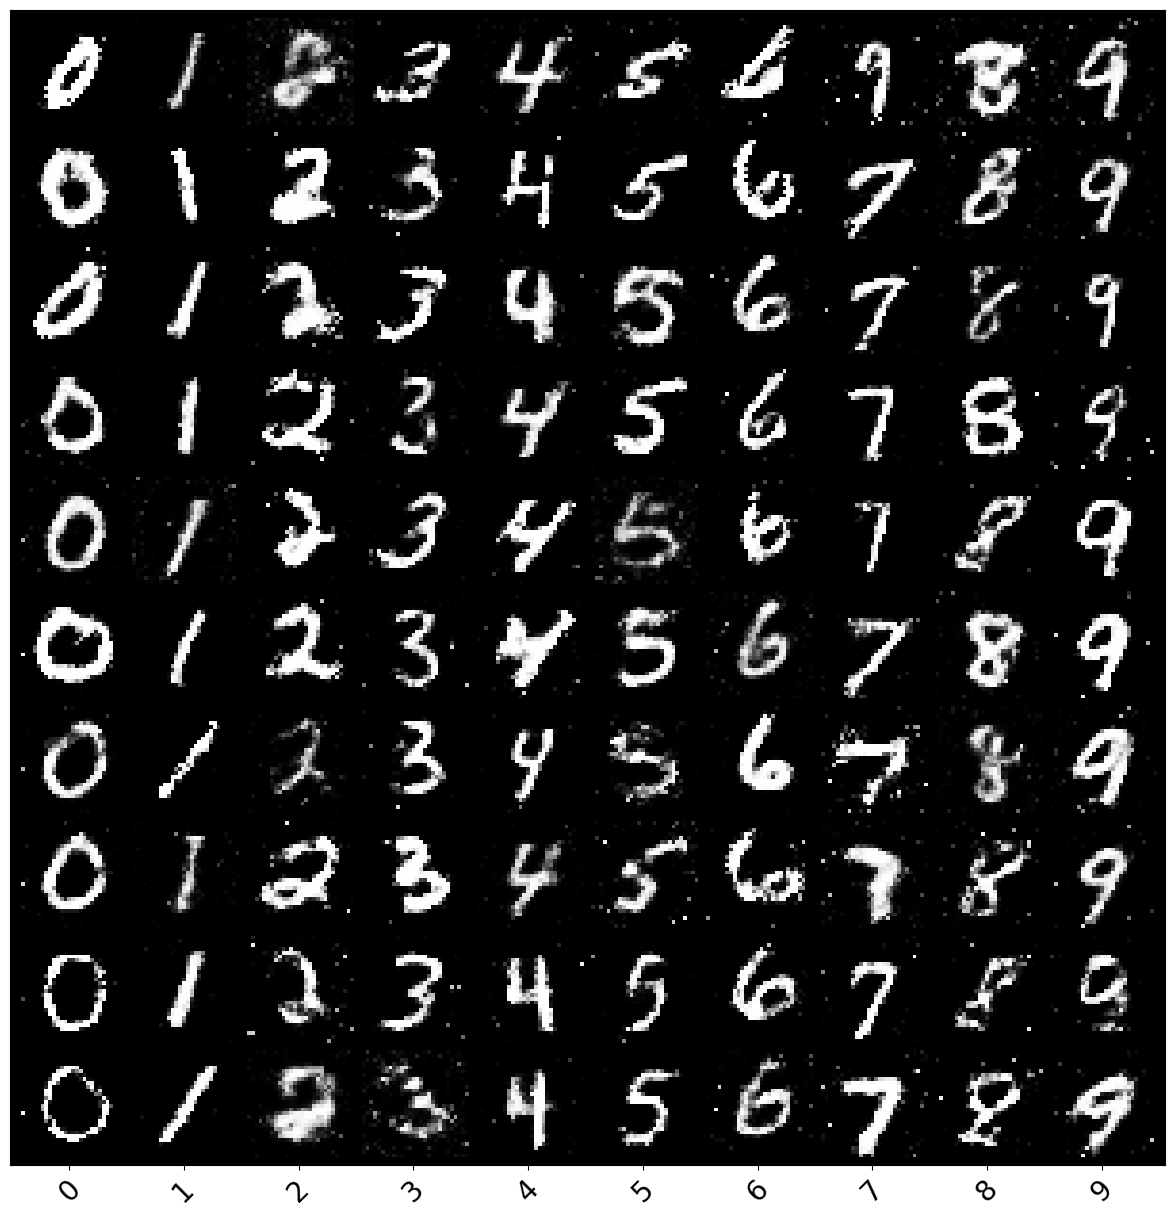

In [ ]:
z = torch.randn(100, 100).cuda()
labels = torch.LongTensor([i for _ in range(10) for i in range(10)]).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['0', '1', '2', '3',\
                                        '4', '5', '6', '7', '8',\
                                        '9'], rotation=45, fontsize=20)

Улучшилось ли качество генерируемых изображений?

Немного улучщилось качество с числами имеющими кружки, но с 2, 3, 5, 6 проблемы остались.

## Задание 2.1. Чувствительность к гиперпараметрам

 Одной из проблем при работе с GAN является очень высокая чувствительность к настройке гиперпараметров. Попробуйте для нашего простого GAN с функцией потерь LSGAN использовать оптимизаторы Adam с learning rate = 1e-4 и дефолтными скользящими параметрами betas.

Обучается ли модель?

In [ ]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

num_epochs = 30
display_step = 300
for epoch in range(num_epochs):
    print(f'Starting epoch {epoch}...')
    for i, (images, labels) in enumerate(data_loader):
        real_images = images.cuda()
        labels = labels.cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)


        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print(f'g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}')
    z = torch.randn(9, 100).cuda()
    labels = torch.LongTensor(np.arange(9)).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

Starting epoch 0...


KeyboardInterrupt: 

In [ ]:
z = torch.randn(100, 100).cuda()
labels = torch.LongTensor([i for _ in range(10) for i in range(10)]).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['0', '1', '2', '3',\
                                        '4', '5', '6', '7', '8',\
                                        '9'], rotation=45, fontsize=20)

Модель, очень плохо обучилась. Теперь она даже 7 плохо генерирует.

# Задание 3. Deeply Convolutional GAN

В первом задании мы реализовали почти точную копию оригинальной GAN-сети. Однако эта архитектура не позволяет получить представления об изображении в пространстве пикселей. Она не способна учитывать такие вещи, как например "резкие края", потому что в ней отсутствуют какие-либо сверточные слои. Поэтому в этом разделе попробуем воссоздать архитектуру [DCGAN](https://arxiv.org/abs/1511.06434), где используются сверточные сети.


### Дискриминатор
Мы хотим присоединять метку класса к объекту. Не очевидным является то, как присоединить ээмбеддинг метки к объекту - картинке. Поэтому давайте разобьем архитектуру дискриминатора на 2 блока: CNN блок и full connected блок. После прогона объекта через CNN блок и разворотом во Flatten, будем добавлять метку и передавать далее в full connected блок.

CNN блок:
* Преобразовать "линейку", получаемую от генератора, в тензор изображения размера 1x28x28 (используйте nn.Unflatten)
* Conv2D, 32 фичи (выходных канала), ядро 5x5 с шагом (stride) 1, функция активации Leaky ReLU (alpha=0.01)
* MaxPool2D, ядро 2x2 с шагом 2
* Conv2D, 64 фичи, ядро 5x5 с шагом 1, Leaky ReLU (alpha=0.01)
* MaxPool2D, ядро 2x2 с шагом 2
* Flatten слой

Full connected блок:
* Полносвязный слой со входом 4 x 4 x 64 + 10 (посчитан из результата конволюций + размер меток) и таким же выходом, Leaky ReLU (alpha=0.01)
* Полносвязный слой с выходом  1

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class DiscriminatorV2(nn.Module):
    def __init__(self):
        #set_random_seed(42)
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.cnn = nn.Sequential(
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28)),
            nn.Conv2d(1, 32, kernel_size=5, stride=1),
            nn.LeakyReLU(0.01),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=5, stride=1),
            nn.LeakyReLU(0.01),

            nn.MaxPool2d(kernel_size=2, stride=2),
            #14x14
            #(14 - kernel_size) / stride + 1 = 7

            nn.Flatten(),
        )

        self.fc = nn.Sequential(
            nn.Linear(1034, 1034),
            nn.LeakyReLU(0.01),
            nn.Linear(1034, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = self.cnn(x) # все конволюции и Flatten
        x = torch.cat([x, c], 1) # приклеиваем метку к объекту уже после прогона через CNN слой
        x = self.fc(x) # все после Flatten
        return x.squeeze()

### Генератор
Для генератора мы точно скопируем архитектуру из статьи [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf)

* Полносвязный слой со входом 100 + 10 (шум + метки) и выходом 1024, ReLU
* BatchNorm1d
* Полносвязный слой с выходом 128 x 7 x 7, ReLU
* BatchNorm1d
* Разворот в тензор картинки 128x7x7 (nn.Unflatten)
* Обратная свертка ([nn.ConvTranspose2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose)), 64 фичи, ядро 4x4 с шагом 2 и 'same' падингом, ReLU
* BatchNorm2d
* Обратная свертка с 1 фичей, ядро 4x4 с шагом 2 и 'same' падингом, TanH
* Должна получиться картинка 28x28 с 1 каналом, разворачиваем в вектор длины 784 (Flatten слой)

In [ ]:
class GeneratorV2(nn.Module):
    def __init__(self, noise_dim=100):
        #set_random_seed(42)
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 128 * 7 * 7),
            nn.ReLU(),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
            nn.Flatten()
        )

    def forward(self, z, labels):
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

Исправленый метод для генератора:

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # Подлинные изображения
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, torch.ones(batch_size).cuda())

    # Сгенерированные изображения
    z = torch.randn(batch_size, 100).cuda() # генерируем шум
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).cuda() # генерируем случайные метки для каждого изображения
    fake_images = generator(z, fake_labels) # собираем в картинку
    fake_validity = discriminator(fake_images, fake_labels) # дискриминатор будет сильно штрафовать генератор если тот сгенерил объект неправильно по метке.
    fake_loss = criterion(fake_validity, torch.zeros(batch_size).cuda())

    d_loss = real_loss + fake_loss

    d_loss.backward()
    d_optimizer.step()

    return d_loss.data

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = torch.randn(batch_size, 100).cuda()
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, torch.ones(batch_size).cuda())

    g_loss.backward()
    g_optimizer.step()

    return g_loss.data

In [ ]:
generator = GeneratorV2().cuda()
discriminator = DiscriminatorV2().cuda()

In [ ]:
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3, betas = (0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas = (0.5, 0.999))

Starting epoch 0...
g_loss: 1.7933, d_loss: 1.0464


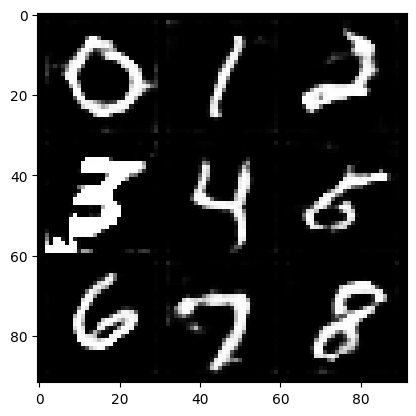

Starting epoch 1...
g_loss: 1.0462, d_loss: 1.1208


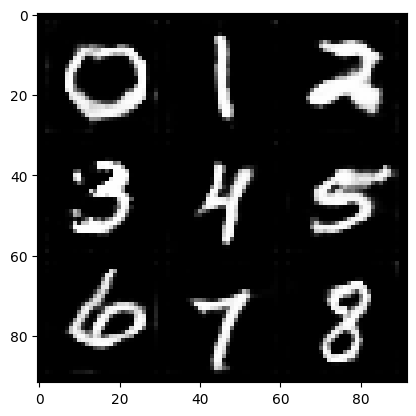

Starting epoch 2...
g_loss: 1.3578, d_loss: 0.9140


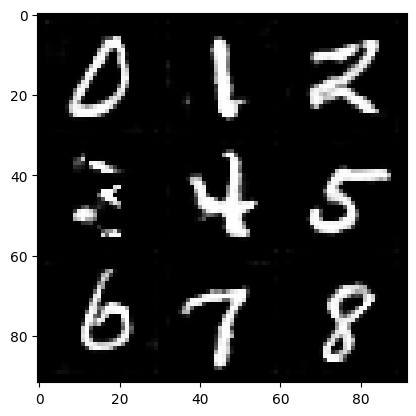

Starting epoch 3...
g_loss: 2.0936, d_loss: 1.5296


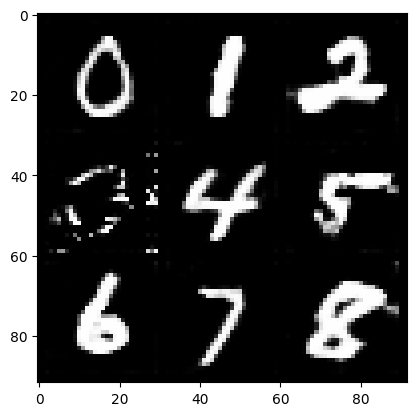

Starting epoch 4...
g_loss: 1.5047, d_loss: 0.7844


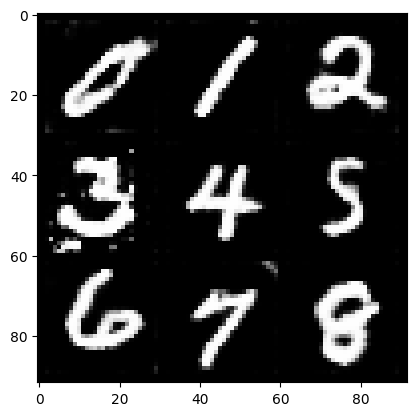

Starting epoch 5...
g_loss: 5.3960, d_loss: 0.9158


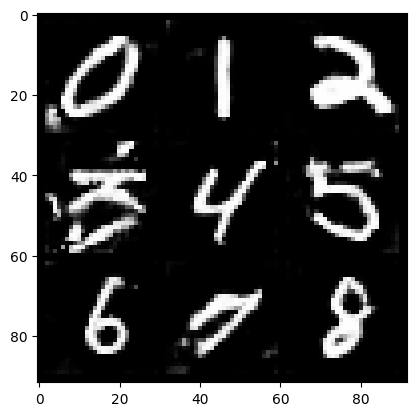

Starting epoch 6...
g_loss: 2.6340, d_loss: 0.8558


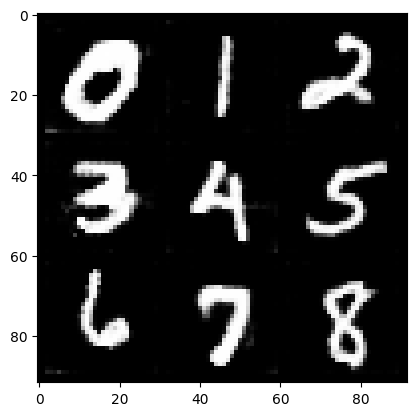

Starting epoch 7...
g_loss: 1.5025, d_loss: 0.6589


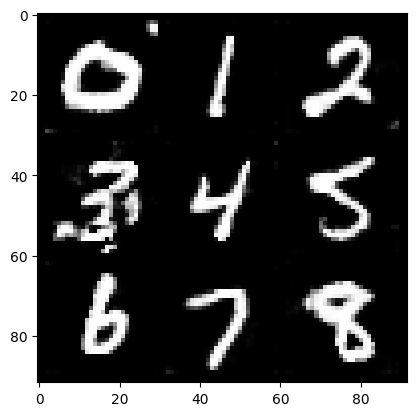

Starting epoch 8...
g_loss: 1.6740, d_loss: 0.7914


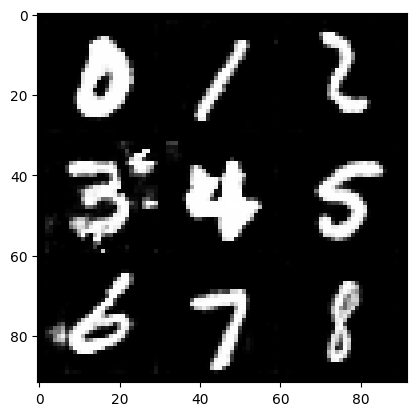

Starting epoch 9...
g_loss: 6.4010, d_loss: 0.6133


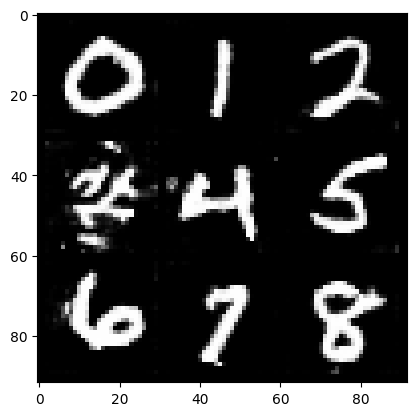

Starting epoch 10...
g_loss: 5.2440, d_loss: 0.5900


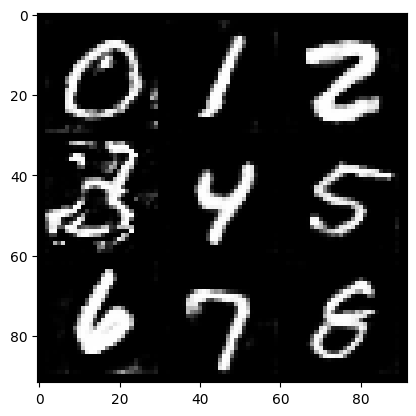

Starting epoch 11...
g_loss: 5.1240, d_loss: 0.7777


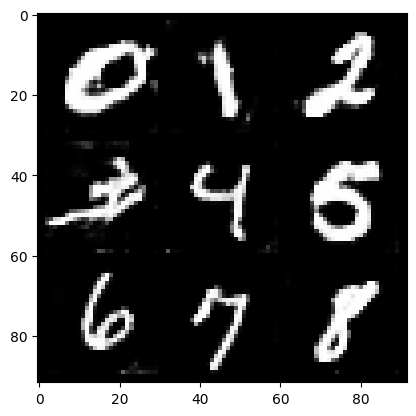

Starting epoch 12...
g_loss: 3.1304, d_loss: 0.6201


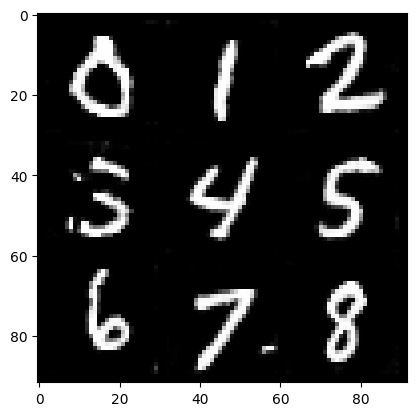

Starting epoch 13...
g_loss: 3.4716, d_loss: 0.5982


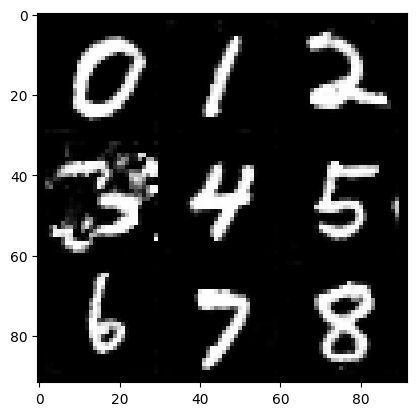

Starting epoch 14...
g_loss: 3.1876, d_loss: 0.5113


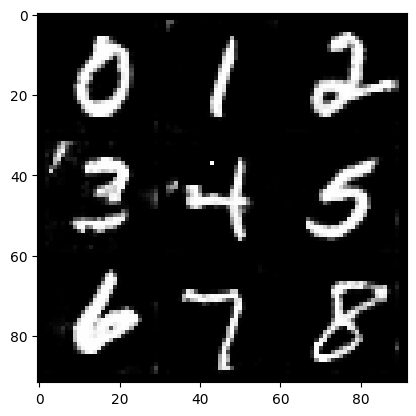

Starting epoch 15...
g_loss: 5.5027, d_loss: 0.5290


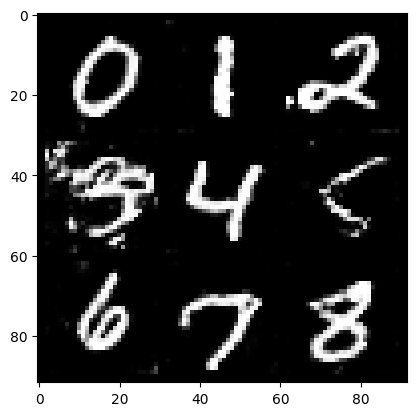

Starting epoch 16...
g_loss: 2.6022, d_loss: 0.4014


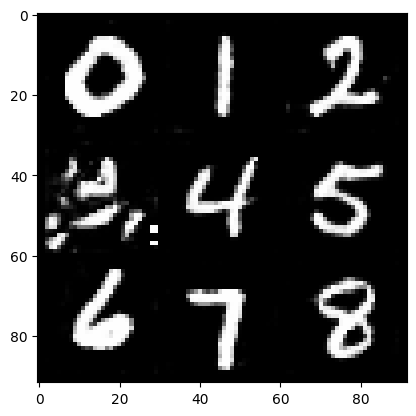

Starting epoch 17...
g_loss: 2.8059, d_loss: 0.4593


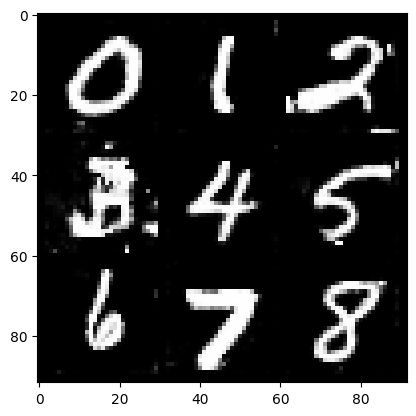

Starting epoch 18...
g_loss: 3.3218, d_loss: 0.4363


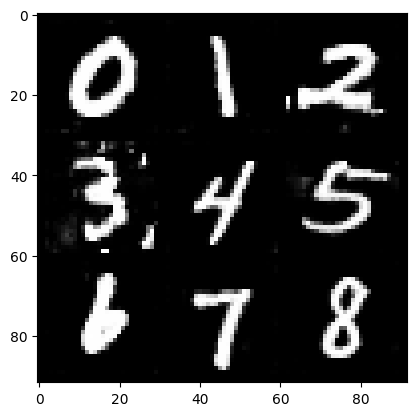

Starting epoch 19...
g_loss: 4.5898, d_loss: 0.5277


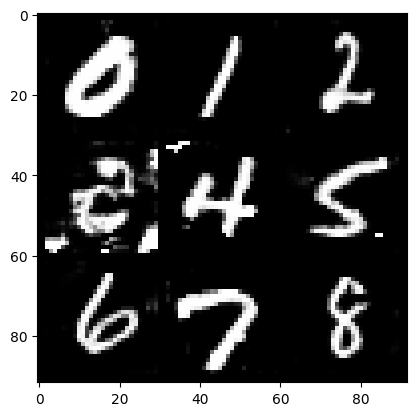

Starting epoch 20...
g_loss: 3.3185, d_loss: 0.5141


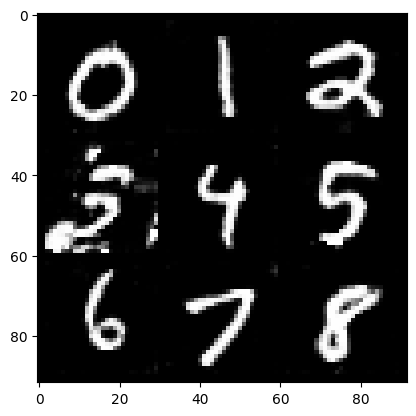

Starting epoch 21...
g_loss: 3.8287, d_loss: 0.4073


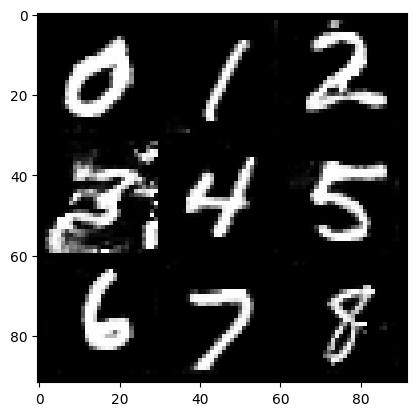

Starting epoch 22...
g_loss: 3.1358, d_loss: 0.5716


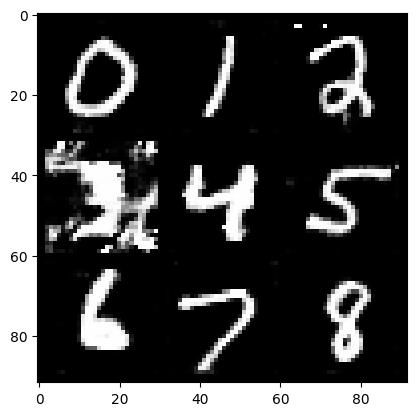

Starting epoch 23...
g_loss: 4.3351, d_loss: 0.7009


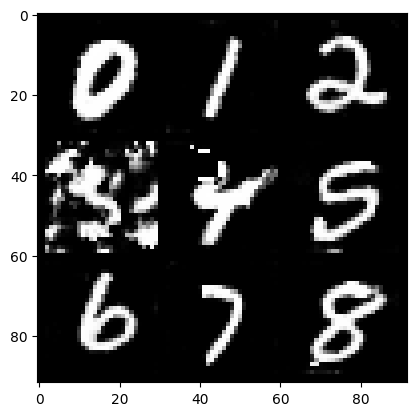

Starting epoch 24...
g_loss: 3.8173, d_loss: 0.3577


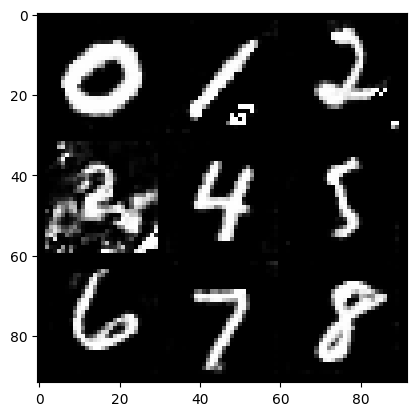

Starting epoch 25...
g_loss: 7.0174, d_loss: 0.3042


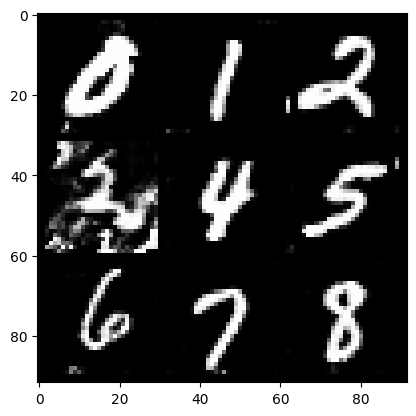

Starting epoch 26...
g_loss: 5.5574, d_loss: 0.3730


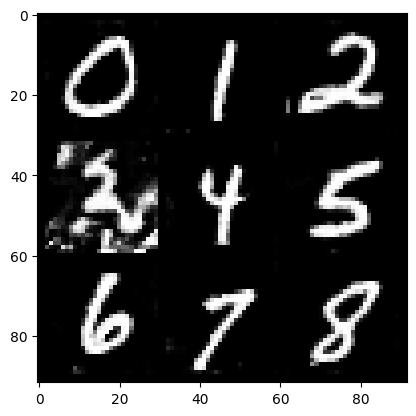

Starting epoch 27...
g_loss: 6.9257, d_loss: 0.2926


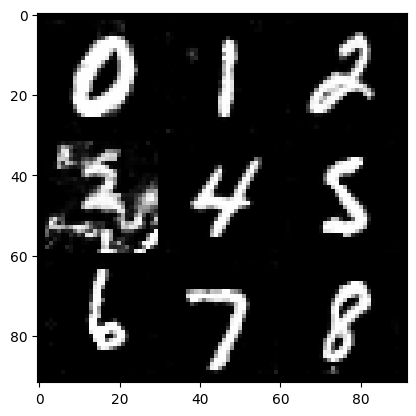

Starting epoch 28...
g_loss: 8.0663, d_loss: 0.5262


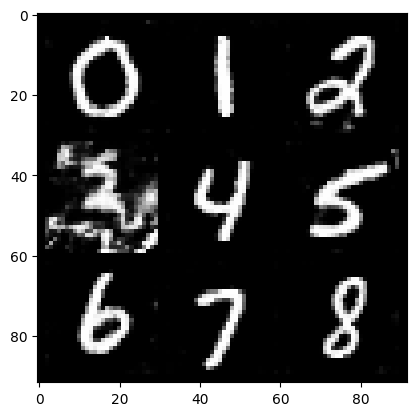

Starting epoch 29...
g_loss: 9.3692, d_loss: 0.2094


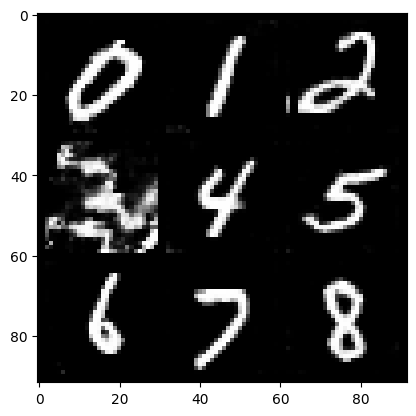

In [ ]:
num_epochs = 30
display_step = 300
for epoch in range(num_epochs):
    print(f'Starting epoch {epoch}...')
    for i, (images, labels) in enumerate(data_loader):
        real_images = images.to(device)
        labels = labels.to(device)
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print(f'g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}')
    z = torch.randn(9, 100).to(device)
    labels = torch.LongTensor(np.arange(9)).to(device)
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

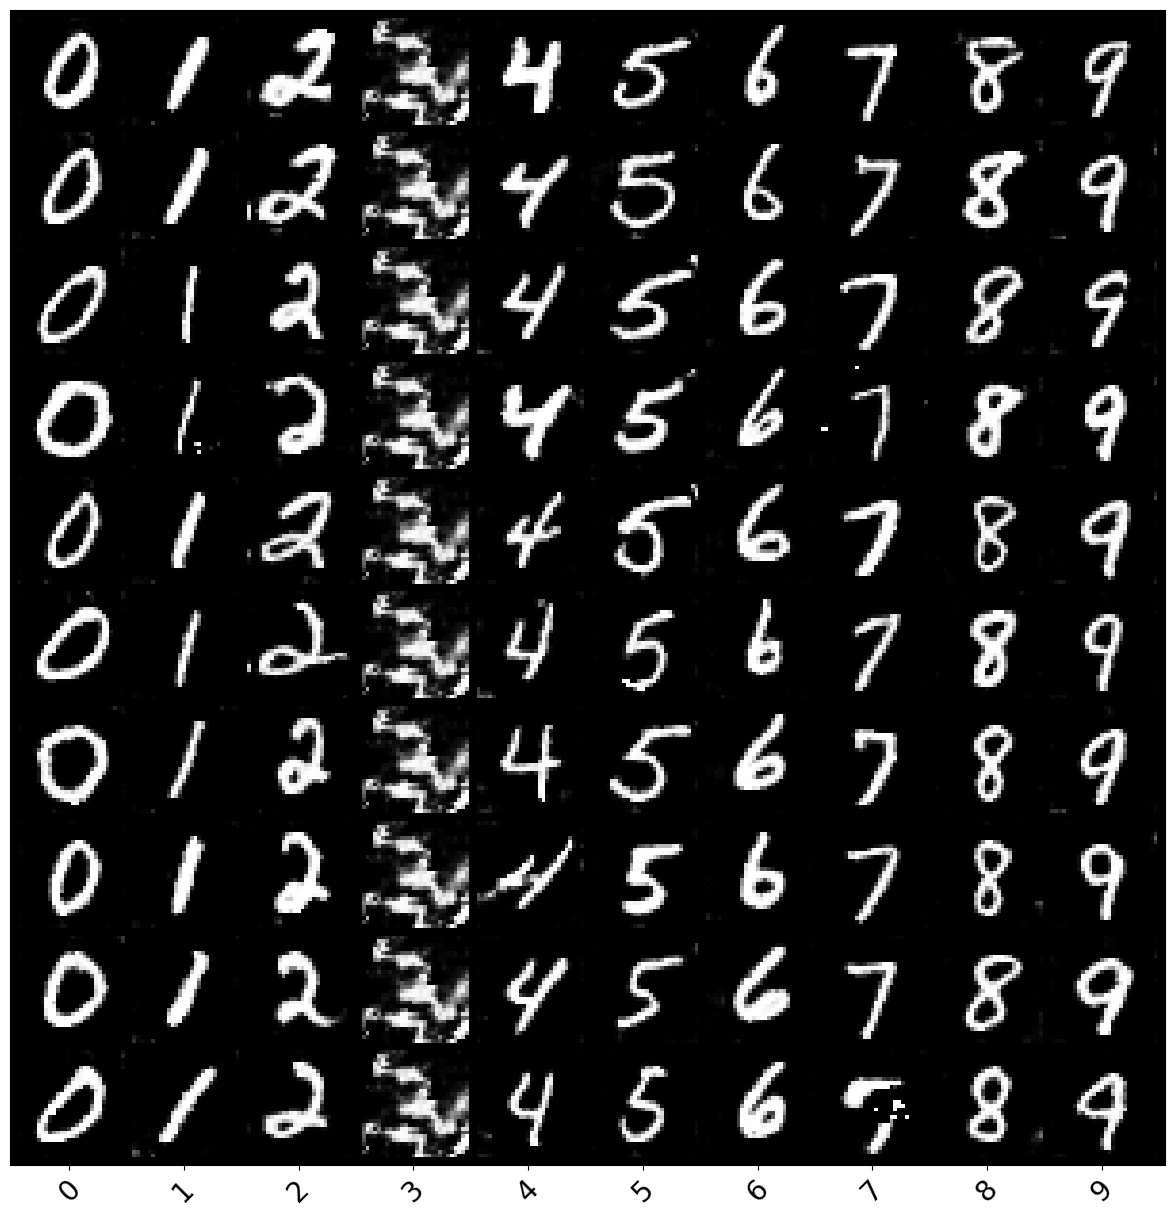

In [ ]:
z = torch.randn(100, 100).cuda()
labels = torch.LongTensor([i for _ in range(10) for i in range(10)]).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['0', '1', '2', '3',\
                                        '4', '5', '6', '7', '8',\
                                        '9'], rotation=45, fontsize=20)

Сравните результаты обучения двух архитектур (простой начальной и DCGAN). Какие выводы можно сделать?

Четкость цифр сильно повысилась, за исключением 3, ее прям уничтожило, причем странно, что все 3 одинаковы.